In [1]:
library("metacell")
library("Matrix")
library("ggplot2")
library("ggrepel")
library("tgstat")
library("zoo")
library("qvalue")
library("devtools")
library("data.table")
library("tidyverse")
library("tglkmeans")
library('RColorBrewer')


Attaching package: 'zoo'


The following objects are masked from 'package:base':

    as.Date, as.Date.numeric


Loading required package: usethis

-- Attaching packages --------------------------------------- tidyverse 1.3.1 --

v tibble  3.1.3     v dplyr   1.0.9
v tidyr   1.2.0     v stringr 1.4.0
v readr   2.1.0     v forcats 0.5.1
v purrr   0.3.4     

-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::between()   masks data.table::between()
x tidyr::expand()    masks Matrix::expand()
x dplyr::filter()    masks stats::filter()
x dplyr::first()     masks data.table::first()
x dplyr::lag()       masks stats::lag()
x dplyr::last()      masks data.table::last()
x tidyr::pack()      masks Matrix::pack()
x purrr::transpose() masks data.table::transpose()
x tidyr::unpack()    masks Matrix::unpack()



In [2]:
source("../scripts/manifold_2d_proj_hr.R")
scdb_init("../scrna_db/", force_reinit=T)

mat_id <- "exe"
mc_id <- "exe"

mat <- scdb_mat(mat_id)
mc <- scdb_mc(mc_id)
gset = scdb_gset("exe")
mc2d <- scdb_mc2d(id = "exe_umap")

md <- mat@cell_metadata

fig_dir <- "../figs/"
if(!dir.exists(fig_dir)) dir.create(fig_dir)
scfigs_init(fig_dir)

initializing scdb to ../scrna_db/



In [3]:
exe_cells = colnames(mat@mat)[mat@cell_metadata[colnames(mat@mat),"Experiment"] != "Wildtype project"]
exe_cells_f = exe_cells[!is.na(md[exe_cells,"time_bin"])]

rank_vs_ct = table(mc@colors[mc@mc[exe_cells_f]],mat@cell_metadata[exe_cells_f,"transcriptional_rank"])
rank_vs_ct = rank_vs_ct[mc@color_key$color,]
rank_vs_ct = t(t(rank_vs_ct)/colSums(rank_vs_ct))

emb_age_df = unique(mat@cell_metadata[exe_cells_f,c("embryo","transcriptional_rank",
                                                    "time_bin","developmental_time")])
emb_age_df = emb_age_df[order(emb_age_df$transcriptional_rank),]

sum_age_exe <- emb_age_df %>% 
  group_by(time_bin) %>% 
  summarise(mean=round(mean(developmental_time),1))
sum_age_exe <- as.data.frame(sum_age_exe)

sc_time_annot = data.frame(cell = exe_cells_f,
                           embryo = mat@cell_metadata[exe_cells_f,"embryo"])
sc_time_annot = left_join(sc_time_annot,emb_age_df,by = "embryo")
f = !is.na(sc_time_annot$developmental_time)
sc_time = sc_time_annot$developmental_time[f]
names(sc_time) = sc_time_annot$cell[f]

col_to_ct =  mc@color_key$group
names(col_to_ct) = mc@color_key$color
ct_to_col = mc@color_key$color
names(ct_to_col) = mc@color_key$group

col_to_rank = c(1:nrow(mc@color_key))
names(col_to_rank) = mc@color_key$color
mc_time = tapply(sc_time,mc@mc[names(sc_time)],mean)
mc_new_ord = as.numeric(names(mc_time[order(as.numeric(mc_time))]))

shades_rdbu <- rev(colorRampPalette(RColorBrewer::brewer.pal(11,name = "RdBu"))(100))
shades_blues <- colorRampPalette(RColorBrewer::brewer.pal(9,"Blues"))(100)
shades_reds <- colorRampPalette(RColorBrewer::brewer.pal(9,"Reds"))(100)
shades_yellows <- colorRampPalette(RColorBrewer::brewer.pal(9,"YlOrBr"))(100)
shades_greys <- colorRampPalette(RColorBrewer::brewer.pal(9,"Greys"))(100)
shades_greens <- colorRampPalette(RColorBrewer::brewer.pal(9,"Greens"))(100)
shades_purples <- colorRampPalette(RColorBrewer::brewer.pal(9,"BuPu"))(100)

annotation_col = data.frame(ct = col_to_ct[mc@colors],stringsAsFactors = F)
rownames(annotation_col) = c(1:nrow(annotation_col))
annotation_colors = list(ct = ct_to_col)

In [4]:
chorion_cls = names(mc@mc)[mc@colors[mc@mc] == mc@color_key$color[1]]
tsc_cls = names(mc@mc)[mc@colors[mc@mc] == mc@color_key$color[2]]
tsc2_cls = names(mc@mc)[mc@colors[mc@mc] == mc@color_key$color[3]]
spt_cls = names(mc@mc)[mc@colors[mc@mc] == mc@color_key$color[4]]
epc_cls = names(mc@mc)[mc@colors[mc@mc] == mc@color_key$color[5]]
tgc_cls = names(mc@mc)[mc@colors[mc@mc] == mc@color_key$color[6]]
ptgc_cls = names(mc@mc)[mc@colors[mc@mc] == mc@color_key$color[7]]
spa_cls = names(mc@mc)[mc@colors[mc@mc] == mc@color_key$color[8]]

chorion_mcs = which(mc@colors == mc@color_key$color[1])
tsc_mcs = which(mc@colors == mc@color_key$color[2])
tsc2_mcs = which(mc@colors == mc@color_key$color[3])
spt_mcs = which(mc@colors == mc@color_key$color[4])
epc_mcs = which(mc@colors == mc@color_key$color[5])
tgc_mcs = which(mc@colors == mc@color_key$color[6])
ptgc_mcs = which(mc@colors == mc@color_key$color[7])
spa_mcs = which(mc@colors == mc@color_key$color[8])

chorion_mcs_ord = mc_new_ord[which(mc_new_ord %in% chorion_mcs)]
tsc_mcs_ord = mc_new_ord[which(mc_new_ord %in% tsc_mcs)]
tsc2_mcs_ord = mc_new_ord[which(mc_new_ord %in% tsc2_mcs)]
spt_mcs_ord = mc_new_ord[which(mc_new_ord %in% spt_mcs)]
epc_mcs_ord = mc_new_ord[which(mc_new_ord %in% epc_mcs)]
tgc_mcs_ord = mc_new_ord[which(mc_new_ord %in% tgc_mcs)]
ptgc_mcs_ord = mc_new_ord[which(mc_new_ord %in% ptgc_mcs)]
spa_mcs_ord = mc_new_ord[which(mc_new_ord %in% spa_mcs)]

mcs_all <- c(tsc_mcs_ord,tsc2_mcs_ord,chorion_mcs_ord,spt_mcs_ord,epc_mcs_ord,tgc_mcs_ord,spa_mcs_ord,ptgc_mcs_ord)
mcs_epc_lineage <- c(tgc_mcs_ord,epc_mcs_ord,spt_mcs_ord)
mcs_chorion_lineage <- c(tsc_mcs_ord,chorion_mcs_ord,tsc2_mcs_ord)

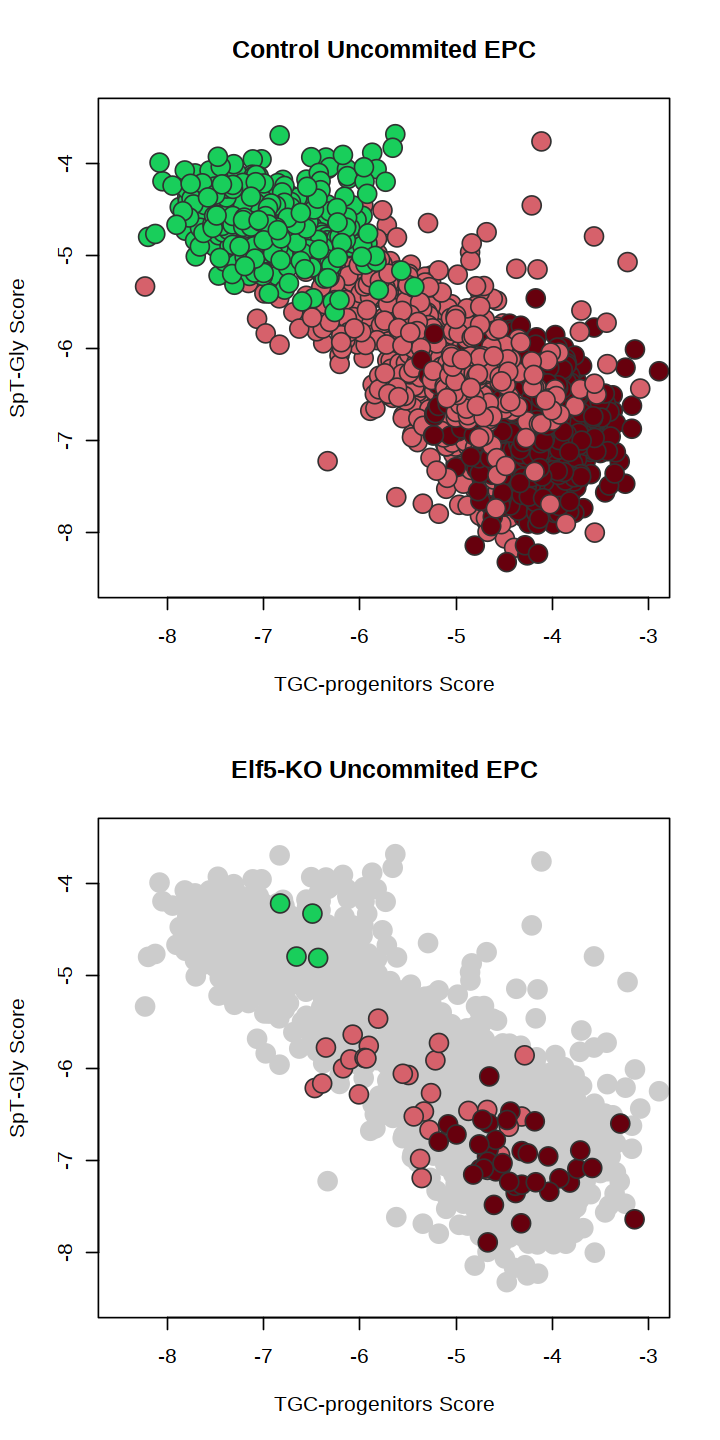

In [18]:
##### EDF3b (EPC) #####
tsc_gm <- read.table("../data/tsc_gene_module.txt",header = T, stringsAsFactors = F, sep = " ")[,1]
tgc_gm <- read.table("../data/tgc_gene_module.txt",header = T, stringsAsFactors = F, sep = " ")[,1]
spt_gm <- read.table("../data/spt_gene_module.txt",header = T, stringsAsFactors = F, sep = " ")[,1]
chorion_gm <- read.table("../data/chorion_gene_module.txt",header = T, stringsAsFactors = F, sep = " ")[,1]

elf5_annotations <- read.csv("../data/elf5_embexe/color_annotation/cell_type_annotation_elf5_cells.tsv",sep ="\t",stringsAsFactors = F)
mat_elf5 = scdb_mat("elf5")
md_elf5 <- mat_elf5@cell_metadata
rownames(elf5_annotations) <- elf5_annotations$cell

cls_elf5_ko <- rownames(elf5_annotations)[elf5_annotations$type == "KO"]
cls_elf5_ko <- cls_elf5_ko[! elf5_annotations[cls_elf5_ko,"cell_type_color"] %in% c("#1A1A1A","#7F6874")] #cls that are not ExE VE or PE
cls_elf5_control <- rownames(elf5_annotations)[elf5_annotations$type == "control"]
cls_elf5_control <- cls_elf5_control[! elf5_annotations[cls_elf5_control,"cell_type_color"] %in% c("#1A1A1A","#7F6874")] #cls that are not ExE VE or PE

elf5_annotations_f <- elf5_annotations[c(cls_elf5_control,cls_elf5_ko),c("cell_type_color","type")]
elf5_df <- elf5_annotations_f[elf5_annotations_f$cell_type_color %in% c("#d6616b","#19ce5b","#67000d"),]

cls_to_use <- intersect(rownames(elf5_df), colnames(mat_elf5@mat))
elf5_df <- elf5_df[cls_to_use,]

tgc_score = colSums(as.matrix(mat_elf5@mat[tgc_gm,cls_to_use]))/colSums(as.matrix(mat_elf5@mat[,cls_to_use]))
tgc_score <- log2(tgc_score + 1e-3)

spt_score = colSums(as.matrix(mat_elf5@mat[spt_gm,cls_to_use]))/colSums(as.matrix(mat_elf5@mat[,cls_to_use]))
spt_score <- log2(spt_score + 1e-3)

elf5_df$tgc_score <- tgc_score
elf5_df$spt_score <- spt_score

cls_epc_lin <- c(epc_cls,tgc_cls,spt_cls,ptgc_cls,spa_cls)
cls_chorion_lin <- c(tsc_cls,chorion_cls,tsc2_cls)

tgc_score_ref <- colSums(as.matrix(mat@mat[tgc_gm,cls_epc_lin]))/colSums(as.matrix(mat@mat[,cls_epc_lin]))
tgc_score_ref <- log2(tgc_score_ref + 1e-3)

spt_score_ref <- colSums(as.matrix(mat@mat[spt_gm,cls_epc_lin]))/colSums(as.matrix(mat@mat[,cls_epc_lin]))
spt_score_ref <- log2(spt_score_ref + 1e-3)

options(repr.plot.width=6, repr.plot.height=12)

df_ko <- elf5_df[elf5_df$type == "KO",]
df_ctrl <- elf5_df[elf5_df$type == "control",]

par(mfrow=c(2,1))

## Control EPC-score
plot(x = tgc_score_ref,
       y = spt_score_ref,
       pch = 21, 
       bg = mc@colors[mc@mc[c(epc_cls,tgc_cls,spt_cls)]],
       col="#313131",
       cex = 2,
       ylim = c(-8.5,-3.5), xlim = c(-8.5,-3),
       main = "Control Uncommited EPC",
       xlab = "TGC-progenitors Score", 
       ylab = "SpT-Gly Score")

## KO EPC-score
plot(x = tgc_score_ref,
       y = spt_score_ref,
       pch = 19, 
       col = "#CCCCCC",
       cex = 2,
       ylim = c(-8.5,-3.5), xlim = c(-8.5,-3),
       main = "Elf5-KO Uncommited EPC",
       xlab = "TGC-progenitors Score", 
       ylab = "SpT-Gly Score")

points(x = df_ko[df_ko$cell_type_color == "#d6616b", "tgc_score"],
       y = df_ko[df_ko$cell_type_color == "#d6616b", "spt_score"],
       cex = 2,
       col="#313131",
       pch = 21,
       bg = "#d6616b")

points(x = df_ko[df_ko$cell_type_color == "#19ce5b", "tgc_score"],
       y = df_ko[df_ko$cell_type_color == "#19ce5b", "spt_score"],
       cex = 2,
       col="#313131",
       pch = 21,
       bg = "#19ce5b")

points(x = df_ko[df_ko$cell_type_color == "#67000d", "tgc_score"],
       y = df_ko[df_ko$cell_type_color == "#67000d", "spt_score"],
       cex = 2,
       col="#313131",
       pch = 21,
       bg = "#67000d")

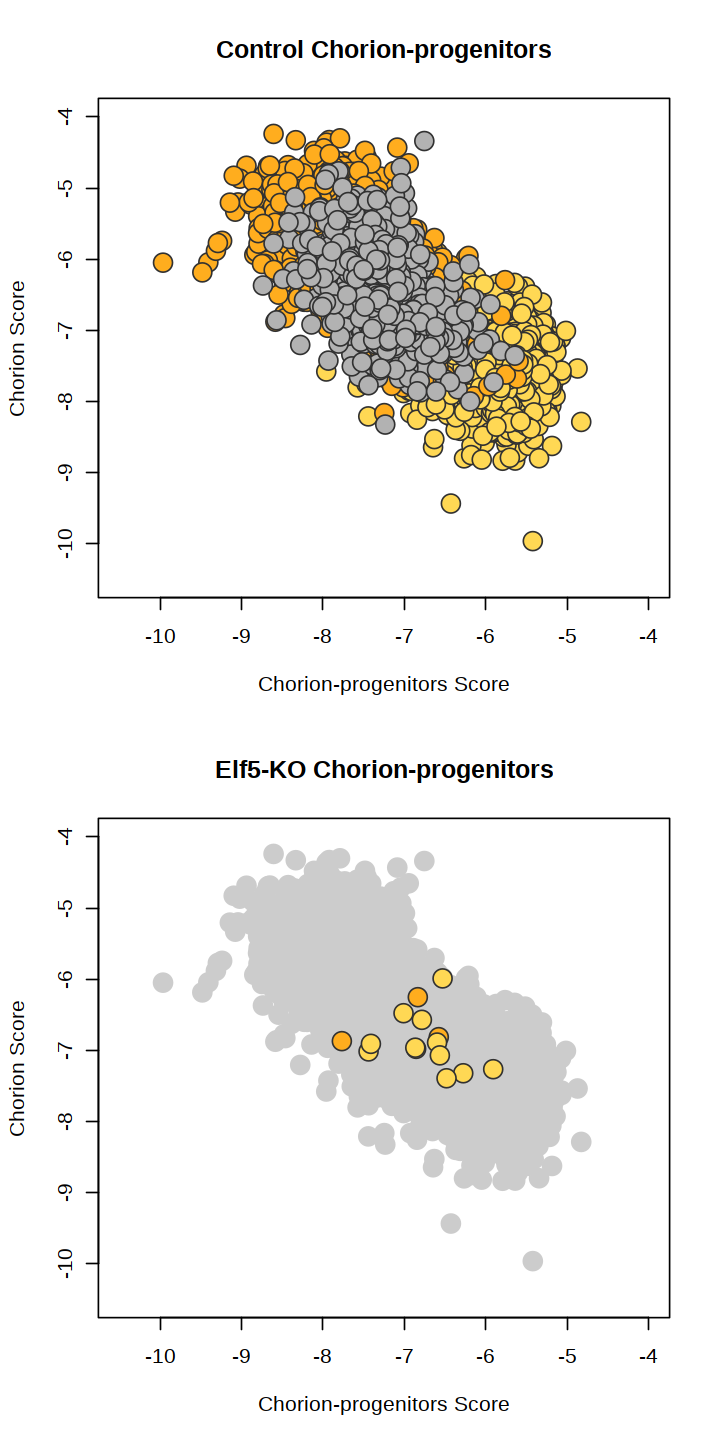

In [19]:
##### EDF3b (Chorion) #####
elf5_annotations_f <- elf5_annotations[c(cls_elf5_control,cls_elf5_ko),c("cell_type_color","type")]
elf5_df <- elf5_annotations_f[elf5_annotations_f$cell_type_color %in% c("#ffd854","#ffad1e"),]

cls_to_use <- intersect(rownames(elf5_df), colnames(mat_elf5@mat))
elf5_df <- elf5_df[cls_to_use,]

tsc_score = colSums(as.matrix(mat_elf5@mat[tsc_gm,cls_to_use]))/colSums(as.matrix(mat_elf5@mat[,cls_to_use]))
tsc_score <- log2(tsc_score + 1e-3)

chorion_score = colSums(as.matrix(mat_elf5@mat[chorion_gm,cls_to_use]))/colSums(as.matrix(mat_elf5@mat[,cls_to_use]))
chorion_score <- log2(chorion_score + 1e-3)

elf5_df$tsc_score <- tsc_score
elf5_df$chorion_score <- chorion_score

tsc_score_ref <- colSums(as.matrix(mat@mat[tsc_gm,cls_chorion_lin]))/colSums(as.matrix(mat@mat[,cls_chorion_lin]))
tsc_score_ref <- log2(tsc_score_ref + 1e-3)

chorion_score_ref <- colSums(as.matrix(mat@mat[chorion_gm,cls_chorion_lin]))/colSums(as.matrix(mat@mat[,cls_chorion_lin]))
chorion_score_ref <- log2(chorion_score_ref + 1e-3)

options(repr.plot.width=6, repr.plot.height=12)

df_ko <- elf5_df[elf5_df$type == "KO",]
df_ctrl <- elf5_df[elf5_df$type == "control",]

par(mfrow=c(2,1))

## Control Chorion-score
plot(x = tsc_score_ref,
       y = chorion_score_ref,
       pch = 21, cex = 2,
       bg = mc@colors[mc@mc[c(tsc_cls,chorion_cls,tsc2_cls)]],
       col="#313131",
       ylim = c(-10.5,-4), xlim = c(-10.5,-4),
       main = "Control Chorion-progenitors",
       xlab = "Chorion-progenitors Score", 
       ylab = "Chorion Score")

## KO Chorion-score
plot(x = tsc_score_ref,
       y = chorion_score_ref,
       pch = 19, 
       col = "#CCCCCC",
       cex = 2,
       ylim = c(-10.5,-4), xlim = c(-10.5,-4),
       main = "Elf5-KO Chorion-progenitors",
       xlab = "Chorion-progenitors Score", 
       ylab = "Chorion Score")

points(x = df_ko[df_ko$cell_type_color == "#ffad1e", "tsc_score"],
       y = df_ko[df_ko$cell_type_color == "#ffad1e", "chorion_score"],
       cex = 2,
       col="#313131",
       pch = 21,
       bg = "#ffad1e")

points(x = df_ko[df_ko$cell_type_color == "#ffd854", "tsc_score"],
       y = df_ko[df_ko$cell_type_color == "#ffd854", "chorion_score"],
       cex = 2,
       col="#313131",
       pch = 21,
       bg = "#ffd854")

points(x = df_ko[df_ko$cell_type_color == "#b2b2b2", "tsc_score"],
       y = df_ko[df_ko$cell_type_color == "#b2b2b2", "chorion_score"],
       cex = 2,
       col="#313131",
       pch = 21,
       bg = "#b2b2b2")



In [36]:
##### EDF5c (DGE epiblast and PS) #####
load("../data/elf5_embexe/color_annotation/cmp_annot.Rda")
mat_wt = scdb_mat("embexe")
mc_wt = scdb_mc("embexe_recolored")

mat_exe <- scdb_mat("exe")
mc_exe <- scdb_mc("exe")
md_exe <- mat_exe@cell_metadata[names(mc_exe@mc),]

mat_emb <- scdb_mat("emb")
mc_emb <- scdb_mc("emb")
md_emb <- mat_emb@cell_metadata[names(mc_emb@mc),]

mat_elf5 = scdb_mat("elf5")
mat_elf5_embexe = scdb_mat("elf5_embexe")
md_elf5 <- mat_elf5@cell_metadata

ko_embs <- c("elf5_exp6_KO_m1e1","elf5_exp4_m1e2","elf5_exp6_KO_m2e3","elf5_ko_exp8_e12")

ko_cls <- rownames(mat_elf5@cell_metadata)[mat_elf5@cell_metadata$embryo %in% ko_embs]
ko_cls <- ko_cls[ko_cls %in% names(cmp_annot$query_cls_col)]
####################################################################################################
# KO emb
epiblast_ko <- names(cmp_annot$query_cls_col[ko_cls])[cmp_annot$query_cls_col[ko_cls] == "#635547"]
primitive_streak_ko <- names(cmp_annot$query_cls_col[ko_cls])[cmp_annot$query_cls_col[ko_cls] == "#DABE99"]

# KO EXE
chp_ko <- names(cmp_annot$query_cls_col[ko_cls])[cmp_annot$query_cls_col[ko_cls] == "#ffd854"]
chp_ko <- chp_ko[chp_ko %in% double_positive_cells]

chorion_ko <- names(cmp_annot$query_cls_col[ko_cls])[cmp_annot$query_cls_col[ko_cls] == "#ffad1e"]
chorion_ko <- chorion_ko[chorion_ko %in% double_positive_cells]

epc_ko <- names(cmp_annot$query_cls_col[ko_cls])[cmp_annot$query_cls_col[ko_cls] == "#d6616b"]
epc_ko <- epc_ko[epc_ko %in% double_positive_cells]

tsc2_ko <- names(cmp_annot$query_cls_col[ko_cls])[cmp_annot$query_cls_col[ko_cls] == "#b2b2b2"]
tsc2_ko <- tsc2_ko[tsc2_ko %in% double_positive_cells]

spt_ko <- names(cmp_annot$query_cls_col[ko_cls])[cmp_annot$query_cls_col[ko_cls] == "#19ce5b"]
spt_ko <- spt_ko[spt_ko %in% double_positive_cells]

tgc_ko <- names(cmp_annot$query_cls_col[ko_cls])[cmp_annot$query_cls_col[ko_cls] == "#67000d"]
tgc_ko <- tgc_ko[tgc_ko %in% double_positive_cells]
####################################################################################################
# WT emb
epiblast_cls <- names(mc_wt@mc)[mc_wt@colors[mc_wt@mc] == "#635547"]
primitive_streak_cls <- names(mc_wt@mc)[mc_wt@colors[mc_wt@mc] == "#DABE99"]

# WT EXE
chp_cls <- names(mc_wt@mc)[mc_wt@colors[mc_wt@mc] == "#ffd854"]
chorion_cls <- names(mc_wt@mc)[mc_wt@colors[mc_wt@mc] == "#ffad1e"]
epc_cls <- names(mc_wt@mc)[mc_wt@colors[mc_wt@mc] == "#d6616b"]
tsc2_cls <- names(mc_wt@mc)[mc_wt@colors[mc_wt@mc] == "#b2b2b2"]
spt_cls <- names(mc_wt@mc)[mc_wt@colors[mc_wt@mc] == "#19ce5b"]
tgc_cls <- names(mc_wt@mc)[mc_wt@colors[mc_wt@mc] == "#67000d"]

####################################################################################################
all_wt_cls <- c(epiblast_cls,
                chp_cls,
                primitive_streak_cls,
                epc_cls,
                tsc2_cls,
                spt_cls,
                tgc_cls,
                chorion_cls)

all_ko_cls <- c(epiblast_ko,
                chp_ko,
                primitive_streak_ko,
                epc_ko,
                tsc2_ko,
                spt_ko,
                tgc_ko,
                chorion_ko)

cls <- c(all_wt_cls,all_ko_cls)
cls <- intersect(cls, colnames(mat_elf5_embexe@mat))



egc <- mat_elf5_embexe@mat[,cls]
legc_n <- t(t(egc)/colSums(egc))

dge_ct <- function(ct){
    wt_cels <- get(x = sprintf("%s_cls", ct),envir = .GlobalEnv)
    ko_cels <- get(x = sprintf("%s_ko", ct),envir = .GlobalEnv)

    dge1 <- matrix(legc_n[,wt_cels])
    dge2 <- matrix(legc_n[,ko_cels])

    title.nm <- sprintf("DGE %s cells WT vs %s Elf5-KO", ct)

    temp <- cbind(dge2[,1],dge1[,1])
    colnames(temp) <- c("gexp.2", "gexp.1")
    temp <- as.data.frame(temp)
    temp$log.2 <- log2(temp$gexp.2 + 1e-05)
    temp$log.1 <- log2(temp$gexp.1 + 1e-05)
    temp$diff.2 <- log2(temp$gexp.2 + 1e-05) - log2(temp$gexp.1 + 1e-05)
    temp$diff.1 <- log2(temp$gexp.1 + 1e-05) - log2(temp$gexp.2 + 1e-05)

    up <- rownames(temp)[temp$diff.1 > 1.3]
    dn <- rownames(temp)[temp$diff.2 > 1.3]

    rnms <- rownames(temp)
    rnms <- subset(rnms , rnms %in% c(up,dn))

    temp$log <- NA
    temp$log[rownames(temp) %in% dn] <- "dn"
    temp$log[rownames(temp) %in% up] <- "up"
    temp$log[which(is.na(temp$log))] <- "n"

    xlims <- c(-17,-5)
    ylims <- c(-17,-5)

    pa <- ggplot(data = temp,aes(log.1,log.2,col=log)) +
      geom_point(size = 12) +
      geom_abline(slope = 1,col="darkgrey") +
      ggtitle(title.nm) +
        xlim(xlims) + 
        ylim(ylims) + 
      xlab(sprintf("Log2(Absolute expression) Elf5-KO %s cells", ct)) +
      ylab(sprintf("Log2(Absolute expression) WT %s cells", ct)) +
        theme(plot.title = element_text(face = "bold",hjust = 0.5)) +

      scale_color_manual(values = c("up"="#000000",
                                    "dn"="#FFD854",
                                    "n"="#CCCCCC"))

    p1 <- pa  + geom_text_repel(data=subset(temp, rownames(temp) %in% rnms),
                                max.overlaps = 50,
                                aes(log.1,
                                    log.2,
                                    label=rnms, 
                                    col  = "#000000",
                                    size = 10), 
                                nudge_x      = 25,
                                direction    = "y",
                                segment.size = 1) +

                geom_point(data=subset(temp, rownames(temp) %in% rnms),
                         aes(log.1,log.2), size = 12) +

                theme(legend.position = "none", text = element_text(size = 12),
                    panel.border = element_rect(fill=NA, size = 1))

    print(p1)
}

dge_ct(ct = "epiblast")
dge_ct(ct = "primitive_streak")

Warning message in cbind(dge2[, 1], dge1[, 1]):
"number of rows of result is not a multiple of vector length (arg 1)"


In [37]:
#### EDF5d (DGE EPCs and Chorions) #####
dge_ct(ct = "chp")
dge_ct(ct = "epc")

In [21]:
#### EDF5e (Gene bar plots) #####
double_positive_cells <- read.csv(file = "../data/elf5_embexe/double_pos_cells.csv")[,2]
load("../data/elf5_embexe/color_annotation/cmp_annot.Rda")
time_match_elf5 <- read.table("../data/elf5_embexe/elf5_infered_transcriptional_age.tsv",sep = "\t")
ko_embs <- c("elf5_exp6_KO_m1e1","elf5_exp4_m1e2","elf5_exp6_KO_m2e3","elf5_ko_exp8_e12")

ko_cls <- rownames(mat_elf5@cell_metadata)[mat_elf5@cell_metadata$embryo %in% ko_embs]
ko_cls <- ko_cls[ko_cls %in% names(cmp_annot$query_cls_col)]
####################################################################################################
# KO emb
epiblast_ko <- names(cmp_annot$query_cls_col[ko_cls])[cmp_annot$query_cls_col[ko_cls] == "#635547"]
primitive_streak_ko <- names(cmp_annot$query_cls_col[ko_cls])[cmp_annot$query_cls_col[ko_cls] == "#DABE99"]

# KO EXE
chp_ko <- names(cmp_annot$query_cls_col[ko_cls])[cmp_annot$query_cls_col[ko_cls] == "#ffd854"]
chp_ko <- chp_ko[chp_ko %in% double_positive_cells]

chorion_ko <- names(cmp_annot$query_cls_col[ko_cls])[cmp_annot$query_cls_col[ko_cls] == "#ffad1e"]
chorion_ko <- chorion_ko[chorion_ko %in% double_positive_cells]

epc_ko <- names(cmp_annot$query_cls_col[ko_cls])[cmp_annot$query_cls_col[ko_cls] == "#d6616b"]
epc_ko <- epc_ko[epc_ko %in% double_positive_cells]

tsc2_ko <- names(cmp_annot$query_cls_col[ko_cls])[cmp_annot$query_cls_col[ko_cls] == "#b2b2b2"]
tsc2_ko <- tsc2_ko[tsc2_ko %in% double_positive_cells]

spt_ko <- names(cmp_annot$query_cls_col[ko_cls])[cmp_annot$query_cls_col[ko_cls] == "#19ce5b"]
spt_ko <- spt_ko[spt_ko %in% double_positive_cells]

tgc_ko <- names(cmp_annot$query_cls_col[ko_cls])[cmp_annot$query_cls_col[ko_cls] == "#67000d"]
tgc_ko <- tgc_ko[tgc_ko %in% double_positive_cells]
####################################################################################################
# WT emb
epiblast_cls <- names(mc_wt@mc)[mc_wt@colors[mc_wt@mc] == "#635547"]
primitive_streak_cls <- names(mc_wt@mc)[mc_wt@colors[mc_wt@mc] == "#DABE99"]

# WT EXE
chp_cls <- names(mc_wt@mc)[mc_wt@colors[mc_wt@mc] == "#ffd854"]
chorion_cls <- names(mc_wt@mc)[mc_wt@colors[mc_wt@mc] == "#ffad1e"]
epc_cls <- names(mc_wt@mc)[mc_wt@colors[mc_wt@mc] == "#d6616b"]
tsc2_cls <- names(mc_wt@mc)[mc_wt@colors[mc_wt@mc] == "#b2b2b2"]
spt_cls <- names(mc_wt@mc)[mc_wt@colors[mc_wt@mc] == "#19ce5b"]
tgc_cls <- names(mc_wt@mc)[mc_wt@colors[mc_wt@mc] == "#67000d"]

####################################################################################################
all_wt_cls <- c(epiblast_cls,
                chp_cls,
                primitive_streak_cls,
                epc_cls,
                tsc2_cls,
                spt_cls,
                tgc_cls,
                chorion_cls)

all_ko_cls <- c(epiblast_ko,
                chp_ko,
                primitive_streak_ko,
                epc_ko,
                tsc2_ko,
                spt_ko,
                tgc_ko,
                chorion_ko)

cls <- c(all_wt_cls,all_ko_cls)

ko_cls_exe <- names(cmp_annot$query_cls_col[ko_cls])[cmp_annot$query_cls_col[ko_cls] %in% mc_wt@color_key$color[43:50]]
wt_cls_exe <- names(mc_wt@mc)[mc_wt@colors[mc_wt@mc] %in% mc_wt@color_key$color[43:50]]

embryo_age_df = md_exe[,c("cell","embryo","time_bin","developmental_time")]
embryo_age_df = embryo_age_df[order(embryo_age_df$developmental_time),]
embryo_age_df <- embryo_age_df[! is.na(embryo_age_df$time_bin),]
rownames(embryo_age_df) <- embryo_age_df$cell

sum_age_embryo <- embryo_age_df  %>%  group_by(time_bin) %>% summarise(mean=round(mean(developmental_time),1))
sum_age_embryo <- as.data.frame(sum_age_embryo)
rownames(sum_age_embryo) <- sum_age_embryo$mean

embryo_age_df <- embryo_age_df[wt_cls_exe,]
embryo_age_df <- embryo_age_df[embryo_age_df$cell %in% colnames(mat@mat),]

elf5_timing_df <- time_match_elf5[time_match_elf5$embryo %in% ko_embs,]
elf5_timing_df <- elf5_timing_df[order(elf5_timing_df$developmental_time),]

sum_times_elf5 <- data.frame("cell" = rownames(mat@cell_metadata)[mat@cell_metadata$embryo %in% elf5_timing_df$embryo],
                             row.names = rownames(mat@cell_metadata)[mat@cell_metadata$embryo %in% elf5_timing_df$embryo],
                             "embryo" = mat@cell_metadata$embryo[mat@cell_metadata$embryo %in% elf5_timing_df$embryo])
sum_times_elf5 <- sum_times_elf5[ko_cls_exe,]
sum_times_elf5 <- sum_times_elf5[sum_times_elf5$cell %in% colnames(mat@mat),]

gene_plot_over_time_bins <- function(gene){
    #### WT gexp
    gene_umis_per_bin_wt = tapply(mat@mat[gene,rownames(embryo_age_df)],embryo_age_df$time_bin,sum)
    gene_umis_per_bin_wt_n = log2(gene_umis_per_bin_wt/total_umis_per_bin_wt + 1e-5)
    names(gene_umis_per_bin_wt_n) <- sum_age_embryo$mean

    sum_gexp_wt <- data.frame("gene" = gene_umis_per_bin_wt_n, 
                              "age" = names(gene_umis_per_bin_wt_n))
    sum_gexp_wt$nms <- paste(" (Et-",sum_gexp_wt$age,")",sep="")

    
    #### KO gexp
    gene_umis_per_ko = tapply(mat@mat[gene,rownames(sum_times_elf5)],sum_times_elf5$embryo,sum)
    gene_umis_per_ko_n = log2(gene_umis_per_ko/total_umis_per_ko + 1e-5)
    gene_mean_ko <- mean(gene_umis_per_ko_n)
    
    sum_ko <- data.frame("gene" = gene_mean_ko, 
                     "age" = as.character(mean(as.numeric(sum_gexp_ko$age))), nms = "KO")

    #### Combind df
    gexp_df <- bind_rows(sum_gexp_wt,sum_ko)
    gexp_df$nms <- factor(gexp_df$nms, levels = c(sum_ko$nms,sum_gexp_wt$nms))
    gexp_df$col <- c(rep("#B2B2B2",6), rep("#BA0000",1))
    gexp_df[,"gene"] <- gexp_df[,"gene"] - log2(1e-5)

    fn <- sprintf("Final_paper_EXE/plot_fig_4/%s.pdf", gene)

    p1 <- ggplot(gexp_df, aes(x = nms, y = gene, fill = col)) + 
    geom_col() +
    ggtitle(sprintf("%s Expression \n Over time-bins",gene)) +
    ylab(gene) +
    scale_fill_identity() +
#     scale_y_continuous(limits = c(0,10), breaks = c(0,10), labels = round(c(0,10) + log2(1e-5))) + 
    theme( plot.title = element_text(size = 10,face = "bold",hjust = 0.5),
          axis.title.x = element_blank(),
          axis.title.y = element_text(size = 10, face = "bold"),
          axis.text.x = element_text(size = 10, face = "bold", angle = 90, hjust = 1, vjust = 0.5),
          axis.text.y = element_text(size = 10, face = "bold"),
            panel.border = element_rect(fill=NA, size = 1))

#     pdf(fn,width = 6, height = 3,useDingbats = F)
    print(p1)
#     dev.off()
    
}


genes_to_plot <- c("Rhox9", "Rhox6")

sum_gexp_ko <- data.frame(age = as.character(round(elf5_timing_df$developmental_time, 1)))

sum_gexp_ko$nms <- paste("KO#",1:4,sep="")

total_umis_per_bin_wt = tapply(colSums(as.matrix(mat_elf5_embexe@mat[,rownames(embryo_age_df)])),embryo_age_df$time_bin,sum)
total_umis_per_ko = tapply(colSums(as.matrix(mat_elf5_embexe@mat[,rownames(sum_times_elf5)])),sum_times_elf5$embryo,sum)

for(gene in genes_to_plot){
    gene_plot_over_time_bins(gene = gene)
}

ERROR: Error in h(simpleError(msg, call)): error in evaluating the argument 'x' in selecting a method for function 'colSums': error in evaluating the argument 'x' in selecting a method for function 'as.matrix': object 'mat_elf5_embexe' not found
